# Modeling Sales Win Rates based on historical CRM data

This project builds an ensemble model used for predicing if a sales opportunity will be won or lost, based on historical CRM data. I'm still working on improving this model.

Upcoming work:
* migrate over some functions from my AirBnB model
* remove the ensemble model
* re-do EDA and rebalance the dataset with more Wins

Simulated opportunity data was generated using Python, an existing CRM dataset from Kaggle, and Google Sheets. No proprietary data or company secrets are in this code. The same code would work for almost any company's CRM export.

Prerequestite: the CRM's CSV export must be processed by a separate Jupyter notebook that prepares the data for training. The original data had 10 columns.

|  |  Actual Win | Actual Lose |
| --- | --- | --- |
| Predicted Win  | Obvious Wins | Unwinnable, should have DQ'ed |
| Predicted Lose | AI was wrong, it was winnable | Obvious Losses - walk away |

Future work ideas:
 * try new classifying estimators available in SciKit Learn, such as: SGD and Passive Aggressive
 * try removing estimators that aren't contributing much to the ensemble model
 * normalize and winsorize certain features before training
 * try a basic neural network classifier using Keras
 * switch to XGBoost for additional options and GPU support
 * run Grid Searches on other metrics: recall and precision
 * investigate the individual sales rep's influence on the opp's win rate. Separate out "how winnable" is the opp and compare to how likely is this specific sales rep to win it?
 * add additional features:
    * product vs managed service
    * include package/bundle information
    * discount information
    * gather more info about time spent in each sales stage


In [1]:
# load dependencies
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from xgboost import XGBClassifier

import multiprocessing

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

# Setting custom parameters for this notebook

In [2]:
filename = os.path.join(
   #os.getcwd(), "data", "salesdata_readytotrain.csv"
   os.getcwd(), "data", "sfdc_masked_readytotrain.csv"
)

# percentage of training data to use for test
TEST_SIZE = 0.2

# random seed
RANDOM_STATE = 12345

# Number of cross validation folds
NUM_CV_FOLDS = 3

# the name for the column that indicates the label/target
# the training CSV file should have headers
LABEL_COLUMN_NAME = "Won"

# acceptable values: accuracy, f1, precision, recall
METRIC_TO_MEASURE = "recall"

# Load and validate the training data

Check that the data does not contain any missing values. The absense of missing values is necessary for training a Decision Tree model.

In [3]:
df = pd.read_csv(filename, header=0)

# verify that there are only numeric and boolean datatypes left
# there should not be any strings left
for index, value in df.dtypes.items():
    assert value in [
        "float64",
        "bool",
        "int64",
    ], f"Column name {index} is not numeric or boolean- found {value}. All features at this point should be numeric or boolean. Exiting."

print("Feature datatype check passed.")

# get a Panda Series of the columns and number of NaNs in each one
nan_count = np.sum(df.isnull(), axis=0)

# iterate through the Series. It could be easier to just throw and exception if
# any have a value of zero.
for index, value in nan_count.items():
    assert (
        value == 0
    ), f"Column name {df.columns[index]} (index = {index}) has {value} missing values (NaN). Decision trees cannot have any missing values. Exiting."

Feature datatype check passed.


# Split up the data

In [4]:
y = df[LABEL_COLUMN_NAME]
X = df.drop(columns=LABEL_COLUMN_NAME, axis=1)

del df # save memory since this variable takes up a lot of space and isn't used again

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [5]:
# GridSearch
generic_model = XGBClassifier(
    objective='binary:logistic',
    #n_jobs=1
    )

clf = GridSearchCV(
    generic_model,
    {"max_depth":     [4, 8, 16],
     "n_estimators":  [200, 400, 800, 1600, 3200],
     "learning_rate": [0.1, 0.01, 0.001]},
    verbose=1,
    n_jobs=-1,
    cv=3,
    scoring=METRIC_TO_MEASURE
)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.157 total time=   0.6s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.147 total time=   0.6s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.145 total time=   0.6s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=400;, score=0.186 total time=   1.0s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=400;, score=0.229 total time=   0.9s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=400;, score=0.178 total time=   0.9s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=800;, score=0.232 total time=   1.6s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=800;, score=0.232 total time=   1.6s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=800;, score=0.290 total time=   1.6s
[CV 1/3] END learning_rate=0.1, max_depth=8, n_estimators=200;, score=0.201 total time=   0.7s
[CV 2/3] END learning_rate=0.1, max_depth=8, n_est

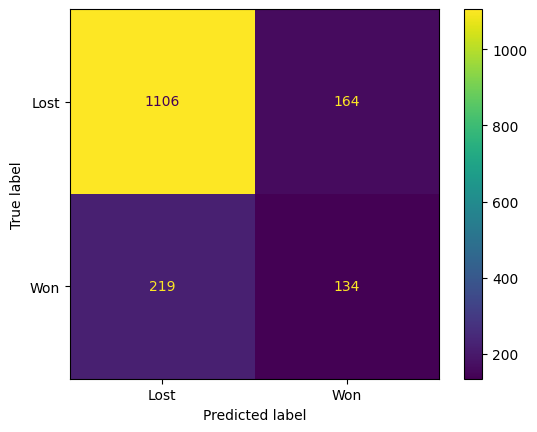

In [6]:
# working single model
bst = XGBClassifier(
    **clf.best_params_
    )
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=bst.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Lost', 'Won'])
disp.plot()
plt.show()

# Hand calculating various metrics

total number of samples: 1623

random accuracy: 354 / 1269 = 0.278959810874704 or 0.721040189125296
accuracy: 1267 + 9 / all = 0.786198398028343

Kappa accuracy: (accuracy - random accuracy )/ random accuracy 
    0.090366958577013

#  Precision: 
Favored in binary classification when FPs are much worse than FNs

<!-- Ex: Judicial system- assume innocence, must have strong evidence to convict (get positive finding) -->

TP / (TP + FP)
9 / (9 + 2) = 0.818181818181818

# Recall:
Favored in binary classification when FN are much worse than FP. Recall used when you want to capture a high rate of the positive cases.

TP / (TP + FN)
9 / (9 + 345) = 0.025423728813559

